### Imports

In [ ]:
import os

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import matplotlib.pyplot as plt
import numpy as np

/home/lweber/.cache/pypoetry/virtualenvs/lfprop-KukTaqIE-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
os.environ["WANDB_API_KEY"] = "your_wandb_api_key_here"  # Replace with your actual API key

dataset_name = "cifar10"
model_name = "deepersnn" #lifcnn lifresnetlike deepersnn

project_name = "your_project_name_here"  # Replace with your actual project name
filters = {
    "config.lr": 0.0005 if model_name == "lifcnn" else 0.0001,
    "config.snn_apply_noise": False,
}
save_path = "your_save_path_here"  # Replace with your actual save path
history_fields = [
    "epoch",
    "train_micro_accuracy_top1",
    "test_micro_accuracy_top1",
    "total_training_time",
]

plot_rstdp = True
rstdp_epochs = [50, 50, 50, 50, 50]

savedir = os.path.join(save_path, "saved_runs")
os.makedirs(savedir, exist_ok=True)

In [3]:

import wandb
import pandas as pd

def download_wandb_runs(project, filters, save_dir, run_fields=None, summary_fields=None, history_fields=None):
    """
    Download runs from wandb with given filters, save their performance across epochs to local files.
    If results already exist locally, load and return them.

    Args:
        project (str): wandb project name, e.g. "user/project".
        filters (dict): wandb API filters, e.g. {"config.lr": 0.01, "config.batch_size": 128}.
        save_dir (str): Directory to save results.
        run_fields (list): List of run fields to fetch (optional).
        summary_fields (list): List of summary fields to fetch (optional).
        history_fields (list): List of history fields to fetch (optional).

    Returns:
        dict: {run_id: pd.DataFrame of history}
    """
    os.makedirs(save_dir, exist_ok=True)
    api = wandb.Api()
    runs = api.runs(project, filters=filters)
    results = {}

    for run in runs:
        run_id = run.id
        run_save_path = os.path.join(save_dir, f"{run_id}.csv")
        # if os.path.exists(run_save_path):
        #     df = pd.read_csv(run_save_path)
        # else:
        # Download run history (performance across epochs)
        history = run.history(keys=history_fields)
        df = pd.DataFrame(history)
        df.to_csv(run_save_path, index=False)
        results[run_id] = df

    return results

# Example usage:
results_grad = download_wandb_runs(
    project=project_name,
    filters={
        **filters, 
        "config.propagator_name": "vanilla-gradient", 
        "config.snn_spike_grad": "step"
    },
    save_dir=savedir,
    history_fields=history_fields
)

results_lfp = download_wandb_runs(
    project=project_name,
    filters={
        **filters, 
        "config.propagator_name": "lfp-epsilon", 
        "config.snn_spike_grad": "step"
    },
    save_dir=savedir,
    history_fields=history_fields
)
if plot_rstdp and model_name in ["deepersnn", "lifresnetlike"]:
    results_rstdp = download_wandb_runs(
        project=f"leanderweber/rstdp-{dataset_name}-{model_name}",
        filters={ 
            "config.propagator_name": "rstdp", 
            "config.epochs": rstdp_epochs,
        },
        save_dir=savedir,
        history_fields=history_fields
    )
else:
    results_rstdp = None

results_grad_surr = download_wandb_runs(
    project=project_name,
    filters={
        **filters, 
        "config.propagator_name": "vanilla-gradient", 
        "config.snn_spike_grad": "atan"
    },
    save_dir=savedir,
    history_fields=history_fields
)

results_lfp_surr = download_wandb_runs(
    project=project_name,
    filters={
        **filters, 
        "config.propagator_name": "lfp-epsilon", 
        "config.snn_spike_grad": "atan"
    },
    save_dir=savedir,
    history_fields=history_fields
)
results_rstdp

{'92yoyfvp':     _step  epoch  train_micro_accuracy_top1  test_micro_accuracy_top1  \
 0       0      1                   0.127829                    0.1560   
 1       1      2                   0.138863                    0.1636   
 2       2      3                   0.140617                    0.1342   
 3       3      4                   0.139106                    0.1345   
 4       4      5                   0.139378                    0.1386   
 5       5      6                   0.133532                    0.1364   
 6       6      7                   0.130846                    0.1472   
 7       7      8                   0.126846                    0.1473   
 8       8      9                   0.129528                    0.1440   
 9       9     10                   0.128988                    0.1071   
 10     10     11                   0.127805                    0.1008   
 11     11     12                   0.122506                    0.1442   
 12     12     13         

In [4]:
# Plot Settings
# Set font properties.
import matplotlib.cm as cm
import matplotlib.font_manager as font_manager

font_path = plt.matplotlib.get_data_path() + "/fonts/ttf/cmr10.ttf"
cmfont = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = cmfont.get_name()
plt.rcParams["mathtext.fontset"] = "cm"

# Set font size.
plt.rcParams["font.size"] = 15

# Disable unicode minus.
plt.rcParams["axes.unicode_minus"] = False

# Use mathtext for axes formatters.
plt.rcParams["axes.formatter.use_mathtext"] = True

plt.rcParams["axes.linewidth"] = 1.5

### Plot Val Accuracies

/tmp/ipykernel_121907/1573806693.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


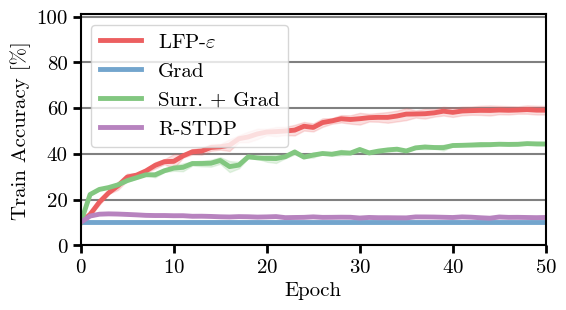

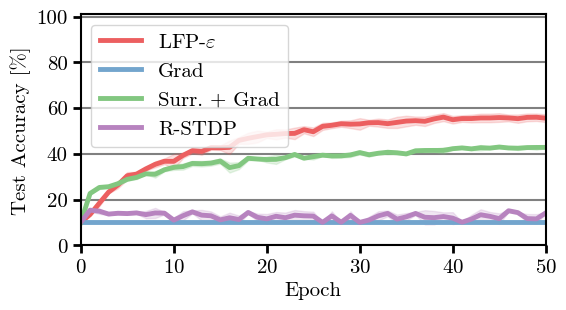

In [5]:

def plot_wandb_accuracies(results_dicts, fname, colormap="Set1", split="test"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))

    SPLITS = {
        "train": "Train",
        "test": "Test"
    }

    LABELS = {
        "lfp-epsilon": r"LFP-$\varepsilon$",
        "vanilla-gradient": r"Grad",
        "vanilla-gradient-surrogate": r"Surr. + Grad",
        #"lfp-epsilon-surrogate": r"Surr. + LFP-$\varepsilon$",
        "rstdp": r"R-STDP",
    }

    for p, prop_name in enumerate(LABELS):
        if prop_name not in results_dicts:
            continue
        runs = results_dicts[prop_name]
        plot_data = []
        for run_id, df in runs.items():                
            if split == "train":
                plot_data.append(df["train_micro_accuracy_top1"].values)
            else:
                plot_data.append(df["test_micro_accuracy_top1"].values)
        plot_data = np.array(plot_data)
            
        plot_means = np.mean(plot_data, axis=0)
        if plot_rstdp and prop_name == "rstdp":
            # If rstdp, only plot up to the last rstdp epoch
            plot_means = np.concatenate(([0.1], plot_means))
        plot_means = plot_means[:rstdp_epochs[-1]+1] if plot_rstdp else plot_means
        plot_stds = np.std(plot_data, axis=0)
        if plot_rstdp and prop_name == "rstdp":
            # If rstdp, only plot up to the last rstdp epoch
            plot_stds = np.concatenate(([0.0], plot_stds))
        plot_stds = plot_stds[:rstdp_epochs[-1]+1] if plot_rstdp else plot_stds
        xaxis = np.arange(len(plot_means))

        ax.plot(xaxis, plot_means, color=palette[p], label=LABELS[prop_name], linewidth=3.5, alpha=1)
        ax.fill_between(
            xaxis,
            plot_means + plot_stds,
            plot_means - plot_stds,
            color=palette[p],
            alpha=0.2,
        )

    linelocs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.hlines(
        linelocs,
        xmin=-1,
        xmax=xaxis[-1],
        color=(0.5, 0.5, 0.5, 1),
        linewidth=1.5,
        zorder=0,
    )

    ax.set_ylabel(f"{SPLITS[split]} Accuracy [%]")
    ax.set_xlabel("Epoch")
    ax.set_ylim([0.0, 1.01])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlim([0.0, xaxis[-1]])
    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    ax.tick_params(length=6, width=2)
    ax.legend()
    plt.show()
    fig.savefig(fname)

# Prepare the dictionary for plotting
results_dicts = {
    "vanilla-gradient": results_grad,
    "vanilla-gradient-surrogate": results_grad_surr,
    "lfp-epsilon": results_lfp,
    "lfp-epsilon-surrogate": results_lfp_surr,
}

if results_rstdp is not None:
    results_dicts["rstdp"] = results_rstdp

plot_wandb_accuracies(results_dicts, os.path.join(save_path, "accuracies-train.svg"), colormap="Set1", split="train")
plot_wandb_accuracies(results_dicts, os.path.join(save_path, "accuracies-test.svg"), colormap="Set1", split="test")

/tmp/ipykernel_121907/3378362971.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


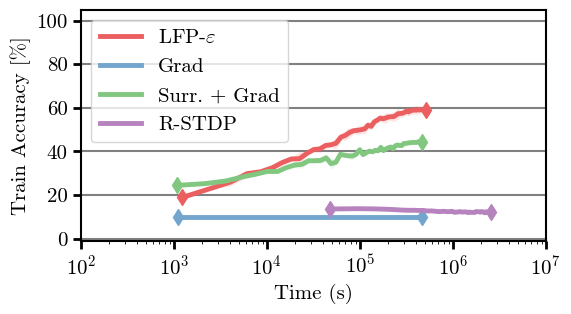

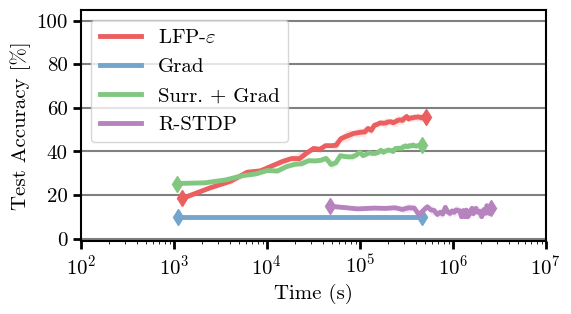

In [7]:
def plot_wandb_accuracies_over_clocktime(results_dicts, fname, colormap="Set1", split="test"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))

    SPLITS = {
        "train": ("train_micro_accuracy_top1", "Train Accuracy [%]"),
        "test": ("test_micro_accuracy_top1", "Test Accuracy [%]")
    }

    LABELS = {
        "lfp-epsilon": r"LFP-$\varepsilon$",
        "vanilla-gradient": r"Grad",
        "vanilla-gradient-surrogate": r"Surr. + Grad",
        #"lfp-epsilon-surrogate": r"Surr. + LFP-$\varepsilon$",
        "rstdp": r"R-STDP",
    }

    for p, prop_name in enumerate(LABELS):
        if prop_name not in results_dicts:
            continue
        runs = results_dicts[prop_name]
        plot_vals = []
        times = []
        for run_id, df in runs.items():
            acc_key = SPLITS[split][0]
            acc = df[acc_key].values[1:] # skip the first value
            time = df["total_training_time"].values[1:] # skip the first value
            plot_vals.append(acc)
            times.append(np.cumsum(time))
        plot_vals = np.array(plot_vals)
        times = np.array(times)
        plot_means = np.mean(plot_vals, axis=0)
        times_mean = np.mean(times, axis=0)
        plot_stds = np.std(plot_vals, axis=0)
        times_stds = np.std(times, axis=0)
        if plot_rstdp and prop_name != "rstdp":
            plot_means = plot_means[1:rstdp_epochs[-1]+1] if plot_rstdp else plot_means[1:]  # skip the first value
            times_mean = times_mean[1:rstdp_epochs[-1]+1] if plot_rstdp else times_mean[1:]
            plot_stds = plot_stds[1:rstdp_epochs[-1]+1] if plot_rstdp else plot_stds[1:]
            times_stds = times_stds[1:rstdp_epochs[-1]+1] if plot_rstdp else times_stds[1:]
    
        # Plot the mean curve
        ax.plot(
            times_mean, plot_means,
            color=palette[p],
            label=LABELS[prop_name],
            linewidth=3.5,
            alpha=1.0
        )
        # Plot marker for the first value
        ax.plot(
            times_mean[0], plot_means[0],
            marker="d",
            color=palette[p],
            markersize=8,
            linestyle="None",
            alpha=1.0
        )
        # Plot marker for the last value
        ax.plot(
            times_mean[-1], plot_means[-1],
            marker="d",
            color=palette[p],
            markersize=8,
            linestyle="None",
            alpha=1.0
        )
        # Plot 2D standard deviation as a shaded region
        ax.fill_betweenx(
            plot_means,
            times_mean - times_stds,
            times_mean + times_stds,
            color=palette[p],
            alpha=0.15,
            linewidth=0
        )
        ax.fill_between(
            times_mean,
            plot_means - plot_stds,
            plot_means + plot_stds,
            color=palette[p],
            alpha=0.15,
            linewidth=0
        )

    linelocs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    logxmax = 10 ** np.ceil(np.log10(ax.get_xlim()[1] if ax.get_xlim()[1] > 0 else 1))

    ax.hlines(
        linelocs,
        xmin=-1,
        xmax=logxmax,
        color=(0.5, 0.5, 0.5, 1),
        linewidth=1.5,
        zorder=0,
    )

    ax.set_ylabel(SPLITS[split][1])
    ax.set_xlabel("Time (s)")
    ax.set_yticks(linelocs)
    ax.set_ylim([-0.01, 1.05])
    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    ax.tick_params(length=6, width=2)
    ax.set_xlim([100, 10000000])
    #ax.legend(bbox_to_anchor=(1.0, 1.05))
    ax.legend()
    ax.set_xscale("log")
    plt.show()
    fig.savefig(fname)

plot_wandb_accuracies_over_clocktime(
    results_dicts,
    os.path.join(save_path, "accuracies-over-clocktime-train.svg"),
    colormap="Set1",
    split="train"
)
plot_wandb_accuracies_over_clocktime(
    results_dicts,
    os.path.join(save_path, "accuracies-over-clocktime-test.svg"),
    colormap="Set1",
    split="test"
)